In [2]:
import os, sys
import numpy as np
import cv2

import torch
import torch.nn.functional as F

from matplotlib import pyplot as plt

sys.path.append('..')
from modeling import SRNsModel
import util
from dataset import data_util
from dataset.face_dataset import _campos2matrix


In [3]:
# _MODEL_PATH = '../checkpoints/050701face_seg_2000_depth.pth'
# _TOT_NUM_INSTANCES = 3714
# _OPT_CAM = False
# _NUM_CLASSES = 17



_MODEL_PATH = os.path.join(
    os.getenv("HOME"), 'liury/log/SRNs/061701face_celebA/checkpoints/epoch_0840_iter_420000.pth')
_TOT_NUM_INSTANCES = 4000
_OPT_CAM = True
_NUM_CLASSES = 20

_IMG_SIZE = 128
_OUT_SIZE = 128

torch.cuda.set_device(0)

In [4]:
model = SRNsModel(num_instances=_TOT_NUM_INSTANCES,
                  latent_dim=256,
                  use_unet_renderer=False,
                  tracing_steps=10,
                  freeze_networks=True,
                  out_channels=_NUM_CLASSES,
                  img_sidelength=_IMG_SIZE,
                  output_sidelength=_OUT_SIZE,
                  opt_cam=_OPT_CAM
                 )

util.custom_load(model, path=_MODEL_PATH, discriminator=None,
                 overwrite_embeddings=False, overwrite_cam=True)

model.eval()
model.cuda()

num instances =  4000
[INIT embedding] optimize camera.


SRNsModel(
  (latent_codes): Embedding(4000, 259)
  (hyper_phi): HyperFC(
    (layers): ModuleList(
      (0): NewCls(
        (hyper_linear): HyperLinear(
          (hypo_params): FCBlock(
            (net): Sequential(
              (0): FCLayer(
                (net): Sequential(
                  (0): Linear(in_features=256, out_features=256, bias=True)
                  (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
                  (2): ReLU(inplace=True)
                )
              )
              (1): FCLayer(
                (net): Sequential(
                  (0): Linear(in_features=256, out_features=256, bias=True)
                  (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
                  (2): ReLU(inplace=True)
                )
              )
              (2): Linear(in_features=256, out_features=1024, bias=True)
            )
          )
        )
        (norm_nl): Sequential(
          (0): LayerNorm((256,), eps=1e-05, elementwise

In [5]:
# _CMAP = np.asarray([[0, 0, 0], [204, 0, 0], [76, 153, 0], [204, 204, 0], [51, 51, 255], [204, 0, 204], [0, 255, 255], [255, 204, 204], [102, 51, 0], 
#                     [255, 0, 0], [102, 204, 0], [255, 255, 0], [0, 0, 153], [0, 0, 204], [255, 51, 153], [0, 204, 204], [0, 51, 0], [255, 153, 51], [0, 204, 0], [0, 204, 153]]).astype(np.float32) / 255.0


_CMAP = np.asarray([[0, 0, 0], [127, 212, 255], [255, 255, 127], [255, 255, 127], # 'background','skin', 'l_brow', 'r_brow'
                    [255, 255, 170], [255, 255, 170], [240, 157, 240], [255, 212, 255], #'l_eye', 'r_eye', 'r_nose', 'l_nose',
                    [31, 162, 230], [127, 255, 255], [127, 255, 255], #'mouth', 'u_lip', 'l_lip'
                    [0, 255, 85], [0, 255, 85], [0, 255, 170], [255, 255, 170], #'l_ear', 'r_ear', 'ear_r', 'eye_g'
                    [127, 170, 255], [85, 0, 255], [255, 170, 127], #'neck', 'neck_l', 'cloth'
                    [212, 127, 255], [0, 170, 255]#, 'hair', 'hat'
                    ])

# _CMAP = np.asarray([[0, 0, 0], [204, 0, 0], [76, 153, 0], [204, 204, 0], [51, 51, 255], [204, 0, 204], [0, 255, 255], [255, 204, 204], [102, 51, 0], 
#                     [255, 0, 0], [102, 204, 0], [255, 255, 0], [0, 0, 153], [0, 0, 204], [255, 51, 153], [0, 204, 204], [0, 51, 0], [255, 153, 51], [0, 204, 0], [0, 204, 153]])

_CMAP =torch.tensor(_CMAP, dtype=torch.float32) / 255.0



# _CMAP = plt.get_cmap('gist_rainbow', 20)(range(20))[:, :3]

#['background'0,'skin'1, 'l_brow'2, 'r_brow'2, 'l_eye'3, 'r_eye'3,'r_nose'4, 'l_nose'5, 'mouth'6, 'u_lip'7,
# 'l_lip'8, 'l_ear'9, 'r_ear'9, 'ear_r'10, 'eye_g'11, 'neck'12, 'neck_l'13, 'cloth'14, 'hair'15, 'hat'16]
# _LABEL = ['background', 'skin', 'brow', 'eye', 
#           'r_nose', 'l_nose', 'mouth', 'u_lip', 'l_lip', 
#           'ear', 'ear_ring', 'eye_glasses', 'neck', 
#           'necklace', 'cloth', 'hair', 'hat']
# _OPA_BIAS = (np.array([0, 9, 10, 11, 12, 13, 14, 15, 16, 8, 7, 6, 5, 4, 3, 2, 1]) * 10.0).astype(int)


_LABEL = ['background', 'skin', 'l_brow', 'r_brow', 'l_eye', 'r_eye','r_nose', 'l_nose', 'mouth', 'u_lip',
'l_lip', 'l_ear', 'r_ear', 'ear_r', 'eye_g', 'neck', 'neck_l', 'cloth', 'hair', 'hat']


# _OPA_SCALE = [0.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 0.75, 0.75, 0.5, 0.75, 0.75, 0.25, 0.5 ]
_OPA_BIAS = (np.array([0, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 6, 5, 4, 3, 9, 2, 7, 8, 1]) * 10.0).astype(int)


def _build_cam_int(focal, H, W):
    return np.array([  [focal, 0., W // 2, 0.],
                       [0., focal, H // 2, 0],
                       [0., 0, 1, 0],
                       [0, 0, 0, 1]])


def render_scene(model, pose, z, focal, img_sidelength, dpt=None):
    
    with torch.no_grad():
        pose = torch.from_numpy(pose).float().unsqueeze(0)
        cam_int = torch.from_numpy(
            _build_cam_int(focal, _IMG_SIZE, _IMG_SIZE)).float().unsqueeze(0)

        uv = np.mgrid[0:_IMG_SIZE, 0:_IMG_SIZE].astype(np.int32)
        uv = torch.from_numpy(np.flip(uv, axis=0).copy()).long()
        uv = uv.reshape(2, -1).transpose(1, 0).unsqueeze(0)

        prob, depth_maps = model(pose, z, cam_int, uv, dpt=dpt)
        pred = torch.argmax(prob, dim=2, keepdim=True)

        prob = F.softmax(prob, dim=2)
        
#         print('*** prob = ', prob.shape, torch.max(prob))
        
        out_img = util.lin2img(pred, color_map=_CMAP).cpu().numpy()
        out_seg = pred.view(img_sidelength, img_sidelength, 1).cpu().numpy()
        
        out_img = (out_img.squeeze().transpose(1, 2, 0)) * 255.0
        out_img = out_img.round().clip(0, 255).astype(np.uint8)

        out_seg = out_seg.squeeze().astype(np.uint8)
        out_prob = prob.squeeze(0).view(
            img_sidelength, img_sidelength, -1).cpu().numpy()
        
        return out_img, out_seg, out_prob

In [6]:
lat_idx = torch.randint(0, _TOT_NUM_INSTANCES, (1,)).squeeze().cuda()
lat_idx = torch.IntTensor([98]).squeeze().cuda()

tensor(2185, device='cuda:0') (128, 128, 20)


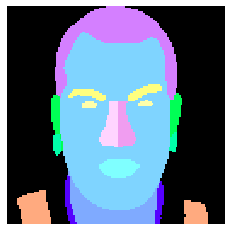

In [7]:
import cv2

lat_idx = torch.randint(0, _TOT_NUM_INSTANCES, (1,)).squeeze().cuda()
latent = model.get_embedding({'instance_idx': lat_idx}).unsqueeze(0)

_DEFAULT_CAM_INT = '../checkpoints/intrinsics.txt'
cam_int = data_util.parse_intrinsics(_DEFAULT_CAM_INT, trgt_sidelength=128)
focal = cam_int[0, 0]

cam_center = np.asarray([0., 0.1, 0.1])
cam_pose = _campos2matrix(np.array([0., 0.0, 1.0])+cam_center, cam_center)
out_img, out_seg, _ = render_scene(model, cam_pose, latent, focal, _OUT_SIZE)

l_nose_idx = np.asarray(np.where(out_seg==5))
r_nose_idx = np.asarray(np.where(out_seg==4))
nose_idx = np.concatenate([l_nose_idx, r_nose_idx], axis=1)        
center = (np.mean(nose_idx[0]), np.mean(nose_idx[1]))

yy = (_OUT_SIZE/2 - center[0])/(focal*4)
xx = (center[1]-_OUT_SIZE/2)/(focal*4)

cam_center = cam_center + np.array([xx, yy, 0.0])
cam_pose = _campos2matrix(np.array([0., 0.0, 1.0])+cam_center, cam_center)

out_img, out_seg, prob = render_scene(model, cam_pose, latent, focal, _OUT_SIZE)
print(lat_idx, prob.shape)

plt.axis('off')
# plt.imshow(cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))
plt.imshow(out_img)
lat_idx += 1

In [8]:
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider, FloatSlider
import ipywidgets as widgets

def render_dpt(dpt, vis_cls):
    out_img, out_seg, prob = render_scene(
        model, cam_pose, latent, focal, _OUT_SIZE, dpt=dpt)
    
    figure=plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.imshow(out_img)
    plt.grid("off");
    plt.axis("off");
    
    plt.subplot(1, 2, 2)
    plt.title(_LABEL[vis_cls])
    plt.imshow(prob[:, :, vis_cls], cmap=plt.get_cmap('magma'))
    plt.grid("off");
    plt.axis("off");

In [9]:
dpt_range = [1.0, 1.75]

dpt_slider = FloatSlider(min=dpt_range[0], max=dpt_range[1], step=0.005)
cls_slider = IntSlider(min=0, max=len(_LABEL)-1, step=1, value=0)
    
interactive_plot = interactive(render_dpt, dpt=dpt_slider, vis_cls=cls_slider)
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(FloatSlider(value=1.0, description='dpt', max=1.75, min=1.0, step=0.005), IntSlider(valu…

In [14]:
# set rgb map for volume rendering

_CCMAP = _CMAP.cpu().numpy()
if np.max(_CCMAP) > 1.0:
    _CCMAP /= 255.0
rgba_map = np.ones((200, 4))

for idx, b_idx in enumerate(_OPA_BIAS):
    s_idx = b_idx
    cur_color = _CCMAP[idx]    
    rgba_map[s_idx:(s_idx+10), :3] = cur_color
    
rgba_map[:10, 3] = 0
rgba_map[10:, 3] = np.linspace(0, 0.05, rgba_map.shape[0]-10)

print(rgba_map)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.66666687e-01 1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.66666687e-01 1.00000000e+00 2.64550265e-04]
 [0.00000000e+00 6.66666687e-01 1.00000000e+00 5.29100529e-04]
 [0.00000000e+00 6.66666687e-01 1.00000000e+00 7.93650794e-04]
 [0.00000000e+00 6.66666687e-01 1.00000000e+00 1.05820106e-03]
 [0.00000000e+00 6.66666687e-01 1.00000000e+00 1.322751

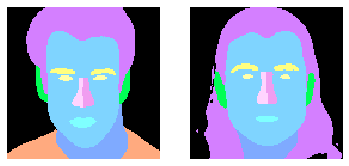

In [17]:
# build density volume for interpolation

import ipyvolume as ipv
import numpy as np
from matplotlib.pyplot import cm

_NUM_INTERPS = 10
_NUM_SLICES = 128

lat_idx = torch.randint(0, _TOT_NUM_INSTANCES, (2,)).squeeze().cuda()
src_latent = model.get_embedding({'instance_idx': lat_idx[0]}).unsqueeze(0)
trgt_latent = model.get_embedding({'instance_idx': lat_idx[1]}).unsqueeze(0)

src_img, _, _ = render_scene(model, cam_pose, src_latent, focal, _OUT_SIZE)
trgt_img, _, _ = render_scene(model, cam_pose, trgt_latent, focal, _OUT_SIZE)

plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(src_img)

plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(trgt_img)

def set_vol_data(figure, framenr, fraction):
#     fraction = 0.5
    
    latent = fraction*trgt_latent + (1.0 - fraction)*src_latent
    full_prob = []

    for dpt in np.linspace(dpt_range[0], dpt_range[1], _NUM_SLICES):
        _, _, prob = render_scene(
            model, cam_pose, latent, focal, _OUT_SIZE, dpt=dpt)
        full_prob.append(np.expand_dims(prob, 0))

    full_prob = np.concatenate(full_prob, axis=0)
    cls_idx = np.argmax(full_prob, axis=-1).astype(int)
    cls_prob = np.max(full_prob, axis=-1)

    cls_prob = cls_prob + _OPA_BIAS[cls_idx]

    ipv.figure()
    ipv.style.axes_off()
    ipv.style.box_off()
    ipv.style.set_style_dark()
    
    vol_data = ipv.volshow(
        np.flip(cls_prob, axis=1), tf=ipv.TransferFunction(rgba=rgba_map), 
        lighting=False, controls=True,
        data_min=0.0, data_max=200)

    vol_data.opacity_scale = 0.6
    vol_data.brightness = 2.0

    ipv.view(160, 0, 1.75)
#     ipv.show()
#     ipv.savefig('%02d.png'%(fraction*_NUM_INTERPS))

In [38]:
# create visualization volume
import ipyvolume as ipv
import numpy as np
from matplotlib.pyplot import cm

# _OPA_BIAS = (np.array([0, 9, 10, 11, 12, 13, 14, 15, 16, 3, 5, 6, 7, 4, 8, 2, 1]) * 10.0).astype(int)

_CCMAP = _CMAP.cpu().numpy()
print('*** _CCMAP = ', _CCMAP.shape)

if np.max(_CCMAP) > 1.0:
    _CCMAP /= 255.0

print(np.max(_CCMAP), lat_idx-1)

rgba_map = np.ones((200, 4))

for idx, b_idx in enumerate(_OPA_BIAS):
    s_idx = b_idx
    cur_color = _CCMAP[idx]    
    rgba_map[s_idx:(s_idx+10), :3] = cur_color

# print('*** rgba_map = ', rgba_map)
# rgba_map = plt.get_cmap('rainbow', 200)(range(200))
rgba_map[:10, 3] = 0
rgba_map[10:, 3] = np.linspace(0, 0.05, rgba_map.shape[0]-10)

full_prob = []

for dpt in np.linspace(dpt_range[0], dpt_range[1], 128):
    _, _, prob = render_scene(
        model, cam_pose, latent, focal, _OUT_SIZE, dpt=dpt)
    
    full_prob.append(np.expand_dims(prob, 0))

full_prob = np.concatenate(full_prob, axis=0)
cls_idx = np.argmax(full_prob, axis=-1).astype(int)
cls_prob = np.max(full_prob, axis=-1)

print('*** cls_prob = ', np.max(cls_prob))

cls_prob = cls_prob + _OPA_BIAS[cls_idx]


# out = widgets.Output(layout={'border': '1px solid black'})

# with out:
ipv.figure()
ipv.style.axes_off()
ipv.style.box_off()
ipv.style.set_style_dark()

vol_data = ipv.volshow(
    np.flip(cls_prob, axis=1), 
    tf=ipv.TransferFunction(rgba=rgba_map), 
    lighting=False, controls=True,
    data_min=0.0, data_max=200)

vol_data.opacity_scale = 0.6
vol_data.brightness = 2.0

ipv.view(160, 0, 1.75)
ipv.show()

# ipv.savefig('test_1.png')

*** _CCMAP =  (20, 3)
1.0 tensor(2902, device='cuda:1')
*** cls_prob =  1.0


In [ ]:
# create visualization volume
import ipyvolume as ipv
import numpy as np
from matplotlib.pyplot import cm

_CCMAP = _CMAP.cpu().numpy()

cls_idx = 8

if np.max(_CCMAP) > 1.0:
    _CCMAP /= 255.0

print(np.max(_CCMAP), lat_idx-1)

rgba_map = np.stack([
        np.linspace(0.0, _CCMAP[cls_idx][0], 200), 
        np.linspace(0.0, _CCMAP[cls_idx][1], 200), 
        np.linspace(0.0, _CCMAP[cls_idx][2], 200),
        np.ones(200)
    ]).T

print('rgba_map = ', rgba_map.shape)

# rgba_map = plt.get_cmap('rainbow', 200)(range(200))
rgba_map[:, 3] = np.linspace(0, 0.1, rgba_map.shape[0])

full_prob = []

for dpt in np.linspace(0.8, 1.1, 128):
    _, _, prob = render_scene(
        model, cam_pose, latent, focal, _OUT_SIZE, dpt=dpt)

    full_prob.append(np.expand_dims(prob, 0))

full_prob = np.concatenate(full_prob, axis=0)
print(full_prob.shape)


# with out:
ipv.figure()
ipv.style.axes_off()
ipv.style.box_off()
ipv.style.set_style_dark()

vol_data = ipv.volshow(
    np.flip(full_prob[:, :, :, cls_idx], axis=1), 
    tf=ipv.TransferFunction(rgba=rgba_map), 
    lighting=False, controls=True,
    data_min=0.0, data_max=1.0)

vol_data.opacity_scale = 0.4
vol_data.brightness = 2.0

ipv.view(205, 10, 2.25)
ipv.show()

# ipv.savefig('test_1.png')

In [ ]:
import ipyvolume as ipv
import numpy as np
from matplotlib.pyplot import cm


for part in ['brow', 
             'skin', 
             'mouth',
             'eye_glasses']:

    ipv.figure()
    ipv.style.axes_off()
    ipv.style.box_off()
    ipv.style.set_style_dark()
    
    vol_data = ipv.volshow(
        vol_prob[part]['data'], 
        tf=ipv.TransferFunction(rgba=vol_prob[part]['cmap']), 
        lighting=False)
    
    ipv.show()

In [ ]:
import plotly.graph_objects as go

X, Y, Z = np.mgrid[0:2.0:32j, 0:2.0:32j, 0:2.0:32j]

# X_idx = (X.flatten()*64.0-1).astype(np.int)
# Y_idx = (Y.flatten()*64.0-1).astype(np.int)
# Z_idx = (Z.flatten()*64.0-1).astype(np.int)

vol = cls_prob

# vol = vol[X_idx, Y_idx, Z_idx]

# print(vol.shape, np.max(vol), np.min(vol))


# vol = vol_prob['skin']['data']
# vol = vol[]
# print(vol.shape)

fig = go.Figure(data=go.Volume(
    x=X.flatten(), 
    y=Y.flatten(), 
    z=Z.flatten(),
    value=vol,
    isomin=0.0,
    isomax=170.0,
    opacity=0.1, # needs to be small to see through all surfaces
    surface_count=64, # needs to be a large number for good volume rendering
    colorscale=rgba_map[:, :3],
    ))

fig.show()

In [ ]:
X, Y, Z = np.mgrid[-8:8:40j, -8:8:40j, -8:8:40j]
values = np.sin(X*Y*Z) / (X*Y*Z)

print(np.max(values), np.min(values))

In [ ]:
import plotly.graph_objects as go


X, Y, Z = np.mgrid[-8:8:40j, -8:8:40j, -8:8:40j]
values = np.sin(X*Y*Z) / (X*Y*Z)

fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=values.flatten(),
    isomin=0.1,
    isomax=0.8,
    opacity=0.1, # needs to be small to see through all surfaces
    surface_count=17, # needs to be a large number for good volume rendering
    ))
fig.show()

In [ ]:
import numpy as np
import ipyvolume as ipv

aquarius = ipv.datasets.aquariusA2.fetch() # 3D data
data = np.moveaxis(np.array([aquarius.data, aquarius.data.T]), 0, -1) # pseudo-4D data

print(data.shape)

ipv.quickvolshow(data)

In [ ]:
ipv.savefig('headless.png', headless=True)